<a href="https://colab.research.google.com/github/Didier06/IA_FABLAB/blob/main/MolecularSolubility2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pysmiles

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pysmiles import read_smiles
import pandas as pd
import logging
from tqdm import tqdm
import torch
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data

logging.getLogger('pysmiles').setLevel(logging.CRITICAL)  # Anything higher than warning

In [ ]:
df = pd.read_csv('dataset.csv') #read dataset (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8)
X_smiles = list(df['SMILES']) #get smiles strings from file
Y = np.asarray(df['Solubility']) #get solubility values from file

elements = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',    #list of all elements in the dataset
            'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce',
            'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al',
            'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn',
            'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd',
            'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C']

#convert element to a one-hot vector of dimension len(elements)
def element_to_onehot(element):
    out = []
    for i in range(0, len(element)):
        v = np.zeros(len(elements))
        v[elements.index(element[i])] = 1.0
        out.append(v)
    return np.asarray(out)

#convert solubility value to one-hot class vector
def val_to_class(val):
    if val < -3.65: #insoluble
        return [1, 0, 0]
    elif val < -1.69: #slightly soluble
        return [0, 1, 0]
    else: #soluble
        return [0, 0, 1]

#process SMILES strings into graphs
nodes = []
edge_index = []
for smiles in tqdm(X_smiles):
    try:
        G = read_smiles(smiles, explicit_hydrogen=True)
        feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1])
        edges = np.asarray(G.edges)
        index = np.asarray([edges[:,0], edges[:,1]]) #reshape indices into shape [2, -1]
        nodes.append(feature)
        edge_index.append(index)
    except:
        pass

100%|██████████| 5494/5494 [00:05<00:00, 989.20it/s] 


In [ ]:
#Generate Data objects
data = list()

#process graphs into torch_geometric Data objects
for i in tqdm(range(0, len(nodes))):
    x = torch.tensor(nodes[i], dtype=torch.float) #convert node features into torch tensor
    edges = torch.tensor(edge_index[i], dtype=torch.long) #convert edge index into torch tensor
    y = torch.tensor([val_to_class(Y[i])], dtype=torch.float) #change shape of label and convert to tensor
    data.append(Data(x=x,edge_index=edges, y=y)) #add the Data object to the list of data
random.shuffle(data)
train = data[:int(len(data)*0.8)] #train set
test = data[int(len(data)*0.8):] #val set
train = data

100%|██████████| 5459/5459 [00:00<00:00, 14118.12it/s]


In [ ]:
#define the message passing network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(61, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, 32)
        self.conv4 = GCNConv(32, 32)
        self.lin1 = Linear(32, 16)
        self.lin2 = Linear(16, 3)

    def forward(self, data):
        x, edge_index= data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv4(x, edge_index)
        x = F.relu(x)

        x = torch.sum(x, dim=0)
        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)


        return x

In [ ]:
#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
model = Net().to(device) #create network and send to the device memory
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
CSE = CrossEntropyLoss() #define loss

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(2): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

100%|██████████| 5459/5459 [00:31<00:00, 171.66it/s]


Epoch: 000, Average loss: 1.04731, Accuracy: 0.46547


100%|██████████| 5459/5459 [00:31<00:00, 173.65it/s]

Epoch: 001, Average loss: 1.02153, Accuracy: 0.49716


In [ ]:
torch.save(model.state_dict(),'/content/model1.pht' )

100%|██████████| 1092/1092 [00:04<00:00, 258.66it/s]


Test accuracy: 0.47985347985347987


(array([346.,   0., 746.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

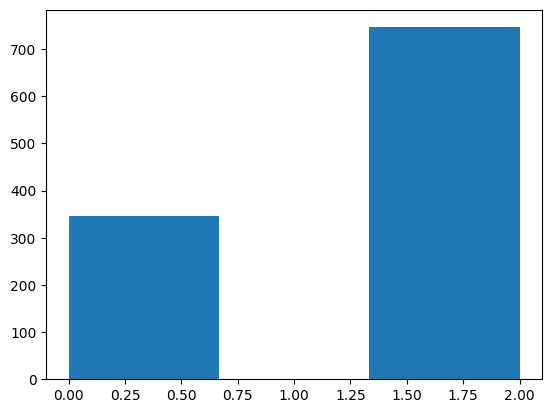

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#test SMILES string
def evaluate_smiles(smiles_string):
    classes = ['insoluble', 'slightly soluble', 'soluble']
    G = read_smiles(smiles_string, explicit_hydrogen=True) #decode smiles string
    feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1]) #convert element to one-hot vector
    edges = np.asarray(G.edges) #get edge array
    index = np.asarray([edges[:,0], edges[:,1]]) #reformat edge array to torch geometric suitable format
    d = Data(x=torch.tensor(feature, dtype=torch.float),edge_index=torch.tensor(index, dtype=torch.long)) #create torch gemoetry Data object
    data = d.to(device) #send data to device memory
    model.eval() #set model to evaluate mode
    print(classes[torch.argmax(torch.softmax(model(data), dim=0)).item()]) #evaluate the test data

In [ ]:
evaluate_smiles('C(C(C1C(=C(C(=O)O1)O)O)O)O') #test out the model on Vitamin C

soluble


In [ ]:
pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 31.5 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

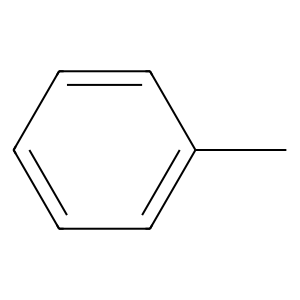

In [19]:
def draw(smile):
    m = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(m)
    return img
draw('Cc1ccccc1')


In [20]:
evaluate_smiles('Cc1ccccc1')

insoluble


insoluble


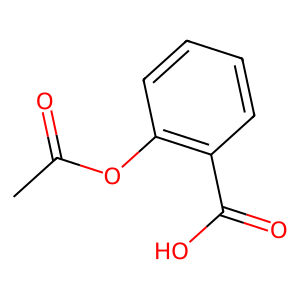

In [21]:
evaluate_smiles('O=C(C1=C(OC(C)=O)C=CC=C1)O') # aspirine
draw('O=C(C1=C(OC(C)=O)C=CC=C1)O')

In [22]:
!pip install kora py3Dmol


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00


In [25]:
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol

def show(smi, style='stick'):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)

    view = py3Dmol.view(width=400, height=400)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()

# example
show('CC')  # or 'P'

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [26]:
show('O=C(C1=C(OC(C)=O)C=CC=C1)O') # aspirine

3Dmol.js failed to load for some reason. Please check your browser console for error messages.